/home/pablo/plytrons/plytrons/bcm_sphere.py:252: RuntimeWarning: invalid value encountered in true_divide
  vector = np.array(vector) / np.array(vector)


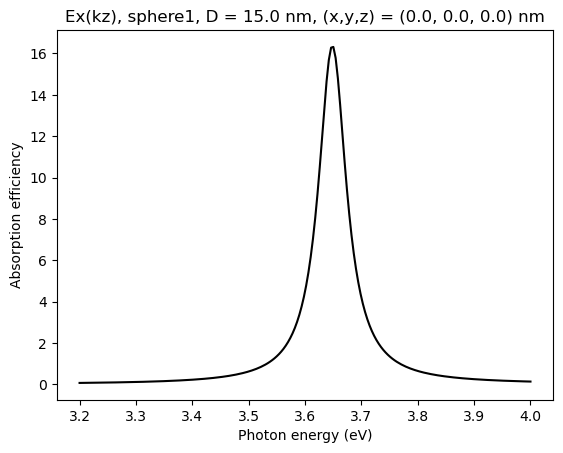

In [1]:
import numpy as np
import plytrons.bcm_sphere as bcm
from plytrons.bcm_sphere import EField, BCMObject
from scipy.constants import hbar, eV, speed_of_light
from scipy.constants import physical_constants
import matplotlib.pyplot as plt

c0 = speed_of_light
Z0, *_ = physical_constants[ "characteristic impedance of vacuum"]
Z0 = Z0 * eV          # Free space impedance (e/V-s)

# Define geometrical parameters
D = 15                      # Diameter of spheres (nm)
lmax = 10                  # Maximum spherical harmonic index

# Define Drude model (silver)
wp = 9.07 * eV / hbar  # rad/s
gw = 0.060 * eV / hbar  # rad/s
eps_b = 4.18

# Define simulation setup
eps_h = 1                                   # Dielectric constant of host
w = np.linspace(3.2, 4.0, 200) * eV / hbar  # frequencies

def eps_drude(x):
    return eps_b - (wp**2) / ((2*np.pi*c0 / x*1E6) * ((2*np.pi*c0 / x * 1E6) + 1j * gw))

efield = EField(
    E0=1,                                 # E-field intensity (V/nm)
    k_hat=bcm.v_normalize([0, 0, 1]),     # Planewave direction
    e_hat=bcm.v_normalize([1, 0, 0])      # E-field vector
)

# Define objects
delta = 2  # gap between spheres (nm)
d_c = D + delta  # center-to-center distance (nm)

BCM_objects = [
    BCMObject(
        label='Sphere1',
        diameter=D,
        lmax=lmax,
        eps=eps_drude,
        position=np.array([0, 0, 0])
    )
    # BCMObject(
    #     label='Sphere2',
    #     diameter=D,
    #     lmax=lmax,
    #     eps=eps_drude,
    #     position=np.array([d_c/2, 0, 0])
    # )

]

# Number of spheres
Np = len(BCM_objects)

# Compute interaction matrices and vector
Gi = [None] * Np
G0 = [[None for _ in range(Np)] for _ in range(Np)]
Sv = [None] * Np

for in_idx in range(Np):
    # Compute internal matrix
    Gi[in_idx] = bcm.Ginternal(BCM_objects[in_idx])
    
    # Compute external interaction matrix
    for jn_idx in range(Np):
        G0[in_idx][jn_idx] = bcm.Gexternal(BCM_objects[in_idx], BCM_objects[jn_idx])
    
    # Compute external field coefficients
    Sv[in_idx] = bcm.Efield_coupling(BCM_objects[in_idx], efield)

#-----------------------------------------------------------------------------------------------------
# Solve system
#-----------------------------------------------------------------------------------------------------
Sw = [None] * Np

dx_max = lmax * (lmax + 1) + (lmax + 1) - 1

obj_coef = []
for coef in range(Np):
    obj_coef.append(np.zeros((dx_max, len(w)), dtype=complex))

for il in range(len(w)):
    c, Si = bcm.solve_BCM(w[il], eps_h, BCM_objects, efield, Gi, G0, Sv)
    for in_idx in range(Np):
        obj_coef[in_idx][:, il] = c[in_idx]
        if il == 0:
            Sw[in_idx] = np.zeros((len(Si[in_idx]), len(w)), dtype=complex)
        Sw[in_idx][:, il] = Si[in_idx]

lam_um = 2*np.pi*3E14/w
for idx_obj in range(Np):
    BCM_objects[idx_obj].set_coefficients(lam_um, obj_coef[idx_obj])

# Compute scattering and absorption
Psca, Pabs = bcm.EM_power(w, eps_h, Gi, G0, BCM_objects)

for in_idx, obj in enumerate(BCM_objects):
    # Plot and save figure of spectrum
    plt.figure()
    Ri = obj.diameter / 2
    plt.plot(w * hbar / eV, Pabs[in_idx] / (efield.E0**2 / (2 * Z0)) / (np.pi * Ri**2), 'k')
    
    plt.title(f'E{bcm.get_axis(efield.e_hat)}(k{bcm.get_axis(efield.k_hat)}), sphere{in_idx+1}, ' +
                f'D = {obj.diameter:.1f} nm, (x,y,z) = ({obj.position[0]:.1f}, {obj.position[1]:.1f}, {obj.position[2]:.1f}) nm')
    plt.xlabel('Photon energy (eV)')
    plt.ylabel('Absorption efficiency')

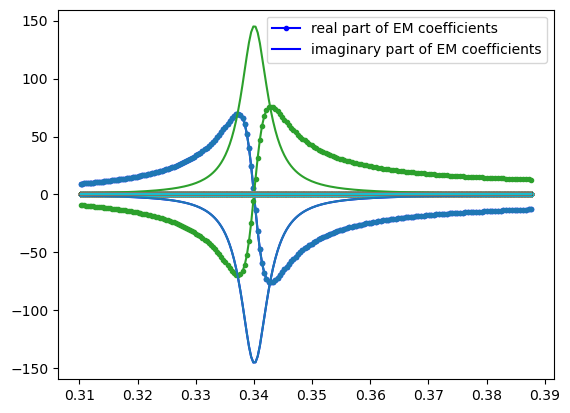

Active l,m -> l=1, m=-1
Active l,m -> l=1, m=1


In [2]:
import numpy as np
from plytrons.plot_utils import print_active_lm

lam  = BCM_objects[0].lam_um
coef = BCM_objects[0].BCM_coef

# first (highlighted) curves with labels
plt.plot(lam, coef.real.T[:,0], 'b.-',  label='real part of EM coefficients')
plt.plot(lam, coef.imag.T[:,0], 'b-',   label='imaginary part of EM coefficients')

# all remaining curves, no legend entries
plt.plot(lam, coef.real.T, '.-',  alpha=1, label='_nolegend_')
plt.plot(lam, coef.imag.T, '-',   alpha=1, label='_nolegend_')

plt.legend()
plt.show()

# usage
print_active_lm(BCM_objects[0], thr=1.0)



## Free electron states

We get electronic states from spherical quantum well

In [3]:
import plytrons.quantum_well as qw

a =  D/2
E_matrix = qw.get_bound_states(a)
A_matrix = qw.get_normalization(a, E_matrix)
e_states = qw.e_state_assembly(E_matrix, A_matrix)

## Predicting hot carrier distribution

In [25]:
from plytrons.math_utils import eps0
from scipy.signal import find_peaks
# ----------------------------------- Simulation set up---------------------------------------------------------------------------
resonance_peak = 1                                                               # Which resonance peak to consider (1, 2, 3, ...)
tau_e = 500                                                                      # hot carrier lifetime (fs)
#---------------------------------------------------------------------------------------------------------------------------------

# hot carrier simulation inputs   
lam_target = lam_um[find_peaks(Pabs[0])[0][resonance_peak-1]]                            # Wavelength at maximum absorption
hv         = 2*np.pi*3E14/lam_target*hbar/eV                                             # photon energy (eV)
EF         = 5.5                                                                         # Fermi level (eV)
Pabs_peak  = Pabs[0][find_peaks(Pabs[0])[0][resonance_peak-1]]/(np.pi*eps0)*1e-15        # Absorption power at peak (eV/ps)
X_lm       = BCM_objects[0].coef_at(lam_target)                                          # EM coefficients

print(f'Wavelength at peak absorption: {lam_target*1e3:.2f} nm')
print(f'Photon energy: {hv:.2f} eV')
print(f'Absorption power at peak: {Pabs_peak:.2f} eV/ps')

Wavelength at peak absorption: 339.89 nm
Photon energy: 3.65 eV
Absorption power at peak: 137581.64 eV/ps


In [5]:
#------------------------------- Hot Carriers Simulation -------------------------------------------------------------------------

from plytrons.hot_carriers import hot_e_dist
Te, Th = hot_e_dist(a, hv, EF, [tau_e], e_states, X_lm, Pabs_peak)

/home/pablo/plytrons/plytrons/hot_carriers.py:291: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  state_lf = e_state[lf]


[check] N_e = 2.929, N_h = 2.943, imbalance = 0.49%
[check] leakage e (outside [EF, EF+hv]): 11.03%
[check] leakage h (outside [EF-hv, EF]): 10.68%


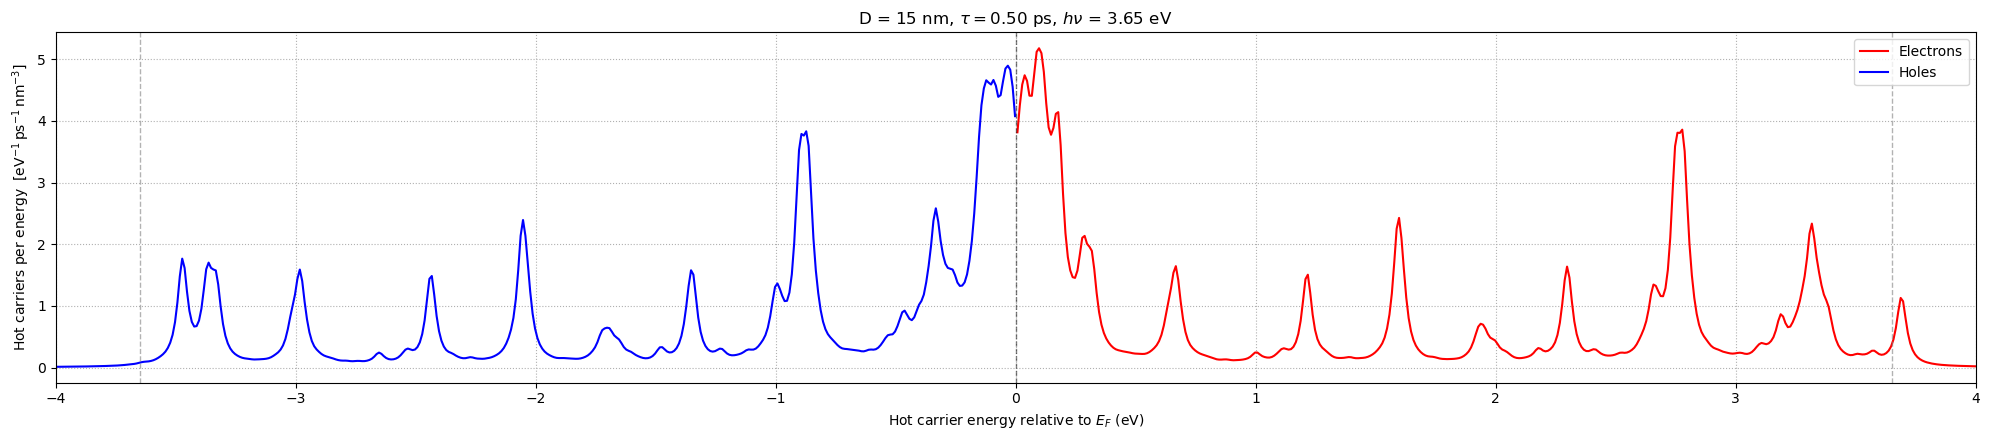

In [26]:
#------------------------------- Plotting ----------------------------------------------------------------------------------------

from plytrons.plot_utils import hot_carriers_plot

# -------------------- edit these to set the plot --------------------
dE_factor = 5             # broadening factor (relative to grid step)
delta = 4.0                # plot window around EF (eV)
DO_CHECKS = True           # set False to skip prints
# --------------------------------------------------------------------

hot_carriers_plot(Te, Th, e_states, tau_e, D, hv, EF, dE_factor, delta, DO_CHECKS)


## Predicting hot carrier dynamics

In [27]:
import numpy as np
from plytrons.hot_carriers import hot_e_dist

# ----------------------------------- Simulation set up-------------------------------------------------------------------------------

resonance_peak = 1                                                                  # Which resonance peak to consider (1, 2, 3, ...)
tau_e = np.linspace(50,1500,59)                                                     # hot carrier lifetime range (fs)
#-------------------------------------------------------------------------------------------------------------------------------------

# hot carrier simulation inputs   
lam_target = lam_um[find_peaks(Pabs[0])[0][resonance_peak-1]]                            # Wavelength at maximum absorption
hv         = 2*np.pi*3E14/lam_target*hbar/eV                                             # photon energy (eV)
EF         = 5.5                                                                         # Fermi level (eV)
Pabs_peak  = Pabs[0][find_peaks(Pabs[0])[0][resonance_peak-1]]/(np.pi*eps0)*1e-15        # Absorption power at peak (eV/ps)
X_lm       = BCM_objects[0].coef_at(lam_target)                                          # EM coefficients

print(f'Wavelength at peak absorption: {lam_target*1e3:.2f} nm')
print(f'Photon energy: {hv:.2f} eV')
print(f'Absorption power at peak: {Pabs_peak:.2f} eV/ps')

Wavelength at peak absorption: 339.89 nm
Photon energy: 3.65 eV
Absorption power at peak: 137581.64 eV/ps


In [8]:
#------------------------------- Hot Carriers dynamics Simulation ----------------------------------------------------------------

from plytrons.hot_carriers import hot_e_dist
Te_dynamics, Th_dynamics = hot_e_dist(a, hv, EF, tau_e, e_states, X_lm, Pabs_peak)

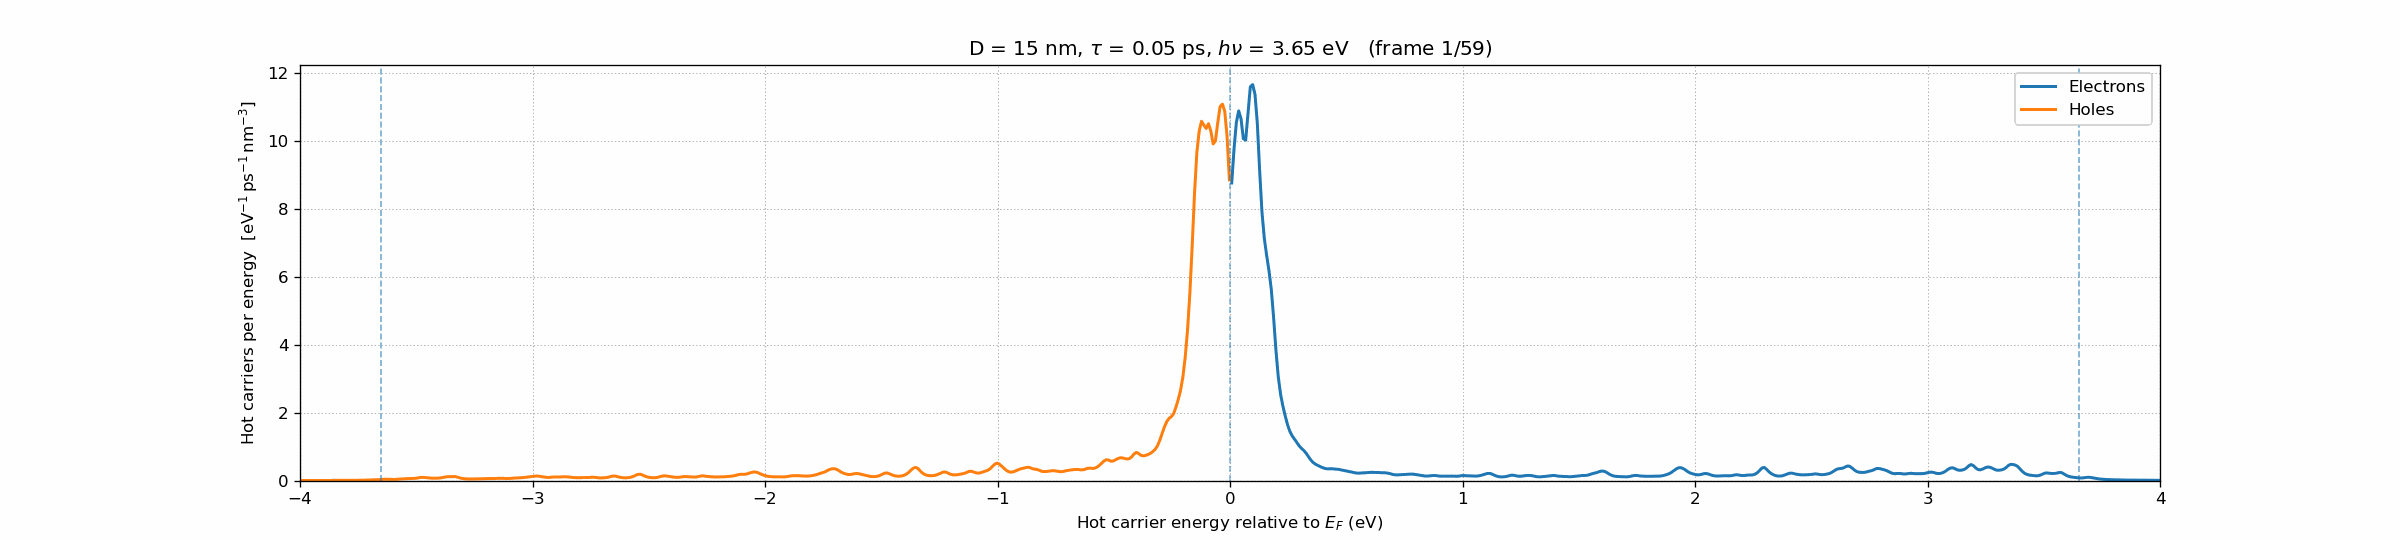

In [28]:
#------------------------------- Animation ---------------------------------------------------------------------------------------


from plytrons.plot_utils import hot_carrier_dynamics_plot

# ===================== editable parameters =====================
EF = 5.5          # eV
dE_factor = 5     # Lorentzian broadening factor (relative to grid step)
delta = 4.0       # eV window around EF for plotting
fps = 6           # frames per second for the GIF
out_path = "hot_carriers_dynamics.gif"  # save path 
use_raw = True    # True -> use Te_raw/Th_raw; False -> use Te/Th (normalized)
# ===============================================================

hot_carrier_dynamics_plot(Te_dynamics, Th_dynamics, e_states, tau_e, D, hv, EF, dE_factor, delta, fps, out_path, use_raw)